# Graded homework 2: Maximum likelihood estimation

This graded homework has 2 exercises. The aim of the exercices is to test the following:
- Python/Numpy/plotting skills
- Using external sources to find the functions you need
- Theoretical comprehension of the notion of:
    1. probability density functions.
    2. Law of large numbers.
    3. Central limit theorem.
    4. Properties of estimators.
    5. Maximum likelihood estimators.

Each question is given in a markdown cell and should be answered in the cell/cells below (you can add cells if needed). The figures must be generated and shown directly in this notebook. 
Remember to add labels for both axes to each plot, even when not explicitly required. 
If a questions demands that you write an answer, use a 'markdown' cell, which can include latex between \\$ symbols. As an example,
\\$\vec{F}=m\vec{a}\\$
gives $\vec{F}=m\vec{a}$.


Your code (including the plotting of the figures) should run  when restarting the kernel and executing all the cells in sequence from top to bottom. 
Running all cells should take a reasonable time on noto (<2 min.).

All the sources you consult should be explicitly cited, except the numpy and matplotlib official documentation, the lecture notes and the previous exercises. You are encouraged to use external sources, since every function needed in this exercise has not necessarily been seen in the previous exercises.
You can cite the sources directly in the cells where you used them by adding either a comment in the Markdown text, or a Python comment in the code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Ex 1: Particle decay

In this exercise, we will look numerically at Example 4 (see chapter 9 of the lecture notes).

A radioactive source emits $n$ unstable particles. The particles are emitted at constant speed along the $x$ axis. For each particle, indexed by  $i\in\{1,\dots,n\}$, we mark the  position $x_i$ where it decays. Our detector however only detects decays between $x_{min}$ and $x_{max}$.

The probability density of decaying at $x$ is 
$$
\rho(x|\lambda_*)=\frac{e^{-x/\lambda_*} }{\lambda_* \left(e^{-x_{min}/\lambda_*}-e^{-x_{max}/\lambda_*}\right)}
$$
for an unknown parameter $\lambda_*$.

Given the dataset of $n$ measurements $\mathbf x=(x_1,\dots,x_n)$ our objective is to estimate $\lambda_*$.


In our case we set $x_{min}=0.5,x_{max}=3,\lambda_*=4$.

In [3]:
lambda_star=4 #value of the parameter that we want to estimate. Also said "ground truth".
xmin=0.5
xmax=3

### Ex 1.1: simulating the particle decay

Your first task is to simulate this physical system, namely to generate the dataset $x_1, x_2, \dots, x_n$ given the true value $\lambda_*$.

To generate the data $\pmb x$, you will use the so called *rejection method*. 
The idea is that the p.d.f. from which we want to sample is just a truncated exponential, i.e. an exponential with scale parameter $\lambda_*$ in which we discard events in which $x < x_{\rm min}$ or $x > x_{\rm max}$.
Thus, we can just generate exponential random numbers using `np.random.exponential` one by one. 
For each sample, we check if $x_{\rm min} < x < x_{\rm max}$. If this is the case, we keep this sample, otherwise we discard it. 
We iterate the procedure until we have $n$ valid measurements.

**1.1.1 (1pt)**

Write a function that takes as input $n$, $\lambda_*$, $x_{\rm min}$ and $x_{\rm max}$ and generates the dataset as a lenght $n$ vector. 

In [4]:
# Solution
def generate_dataset_decay(n, lambda_star, xmin, xmax):
    samples = []
    while len(samples)<n:
        x = np.random.exponential(scale = lambda_star)
        if xmin <= x <= xmax:
            samples = np.append(samples, x)
    return samples

**1.1.2 (1pt)**

Generate a dataset with $x_{min}=0.5,x_{max}=3,\lambda_*=4$. and $n=2000$ and plot its histogram. 
Use ```density = True``` (to have the histrogram represent a p.d.f.) and the x axis limits to $(0, 5)$.

You will observe the truncations at $x_{min}$ and $x_{max}$ and (albeit very noisily) the exponential decay of the distribution.

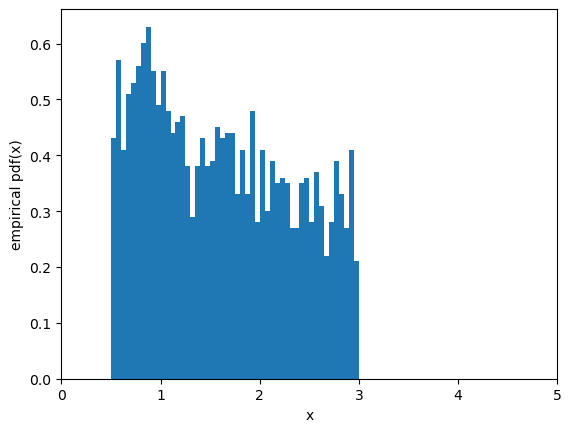

In [5]:
# Solution
n = 2000
dataset_decay = generate_dataset_decay(n, lambda_star, xmin, xmax)
plt.hist(dataset_decay, bins = 50, density = True)
plt.xlabel("x")
plt.ylabel("empirical pdf(x)")
plt.xlim(0,5)
plt.show()

### Ex 1.2: computing the maximum likelihood estimator

Review Example 4 in chapter 9 of the lecture notes. There, we derived the maximum likelihood estimator for $\lambda_*$ as 
$$
\hat{\lambda} 
    = \arg\max_{\lambda} \frac{e^{-\frac{1}{\lambda n}\sum_{i=1}^n x_i} }{\lambda \left( e^{-x_{\rm min} / \lambda} - e^{-x_{\rm max} / \lambda} \right)}  
    = \arg\max_{\lambda} \mathcal{L}(\lambda)
    \, .
$$
It is easier to work with the negative normalized log-likelihood $- \frac{1}{n} \log \mathcal{L}(\lambda)$, which needs to be minimised (due to the negative sign), giving
$$
    \hat \lambda=\arg\min_\lambda \ell(\lambda)
$$
where
$$
\ell(\lambda) =
\log\lambda + \log\left(e^{-x_{min}/\lambda}-e^{-x_{max}/\lambda}\right) + \frac{1}{\lambda} \frac{1}{n}\sum_{i=1}^n x_i \, .
$$

**1.2.1 (1pt)**
Complete the code below to implement the $\ell(x)$ function. Notice that ```lambda``` is a reserved keyword in python, so we use ```l```.

In [6]:
# Solution
def ell(l, xmin, xmax, dataset): 
    return np.log(l) + np.log(np.exp(-xmin/l)-np.exp(-xmax/l)) + np.mean(dataset) / l

**1.2.2 (1pt)** Use the function ```scipy.optimize.minimize``` to numerically minimize $\ell(\lambda)$ for the dataset generated in 1.1.2 and compute the MLE. Use ```0.1``` for the initial condition of the minimization. Print the MLE that you obtain.

Hint: ```scipy.optimize.minimize``` expects a function of the form ```f(l)```, while our function is of the form ```f(l, params)```. 
This happens often.
The way to deal with this is through lambda functions, also called anonymous functions:
```
    scipy.optimize.minimize(lambda l: f(l, params), ...)
```
The keyword ```lambda``` introduces the anonymous function, ```l``` is the variable of the function, and whatever comes after the semicolon `:` is the body of the function.
You can think of the expression 
```
    lambda l: f(l, params)
```
as a shorthand for
```
    def f2(l):
        return f(l, params)
```
with the advantages of

1. not giving a name (```f2``` in the example) to a function that you will use only once.
2. Not defining a function in which we hardcode a global variable (```dataset``` in the example).

In [7]:
# Solution
lambda_hat = (scipy.optimize.minimize(lambda a: ell(a, xmin, xmax, dataset_decay), 0.1).x)[0]
print(lambda_hat)

3.7844540129466675


**1.2.3 (1pt)** Plot the function $\ell(\lambda)$ as a function of $\lambda$ using the given dataset. 
Additionaly, plot a vertical line at the MLE estimator $x = \hat{\lambda}$ that you computed in 1.2.2, and another vertical line at the value $x = \lambda_*$.
Set the x axis limits to $(2,10)$ and add a legend.

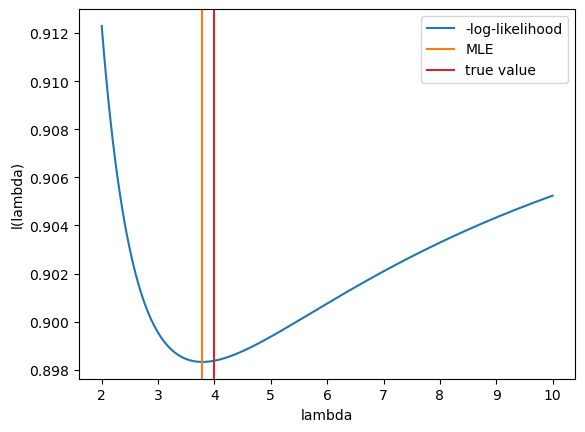

In [8]:
# Solution
xs = np.linspace(2,10,200)
ys = [ ell(x, xmin, xmax, dataset_decay) for x in xs]
plt.plot(xs, ys, label = "-log-likelihood")
plt.xlabel("lambda")
plt.ylabel("l(lambda)")
plt.axvline(x=lambda_hat, color = "tab:orange", label="MLE")
plt.axvline(x=lambda_star, color = "tab:red", label="true value")
plt.legend()

**1.2.4 (1pt)** 
The ```scipy.optimize.minimize``` uses under the hood sophisticated minimization methods, but for the sake of the argument let us imagine that it is using gradient descent to minimize the function $\ell$. Discuss the following points:

- does gradient descent converge to the global optimum in general (i.e. not in this specific case), and what are the consequences for the MLE if it does not? 
- In this case, does gradient descent converge to the global optimum of the likelihood?

Motivate your answers.

**Solution**

In general, the maximum likelihood estimator is the global maximum of the likelihood. In a generic problem, the likelihood may have local maxima, and gradient descent may return a wrong estimate of the MLE.

In our case, the function we are minimising, which is a proxy for the maximisation of the likelihood, seems to have only one global minimum in the interval $2 < \lambda < 10$ (see plot above). Thus we may avoid worrying about local extrema as long as we initialise our optimiser in this region.

## Ex 2: The lighthouse

A lighthouse is placed on a small island in front of the coastline. 
In a coordinate system in which the coast is the $x$ axis, and the $y$ axis points towards open sea, the island is at position $(\alpha_*, 1)$.
The lighthouse emits a series of short flashes at random intervals and hence in random directions $\theta$ (uniformly at random over the full angle of $2\pi$).
These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not the angle from which it came.

In this exercise, we will consider the estimation task of finding the true position $\alpha_*$ of the lighthouse along the coastline, assuming that 
- the angle $\theta$ at which each light pulse is emitted is a uniformly distributed random variable on the interval $(-\pi/2, \pi/2)$ (the angle is measured with respect to the negative-vertical axis, see figure)
- a dataset of $n$ detected positions $x_1, x_2, \dots, x_n$ is given (each detection is statistically independent from the others).

![](lighthouse.png)

### Ex 2.1: simulating the lighthouse, i.e. generating the dataset of measurements

Your first task is to simulate this physical system, namely to generate the dataset $x_1, x_2, \dots, x_n$ given the true value $\alpha_*$.
To do this, we are going to generate randomly the angle $\theta_i$ at which a light pulse is emitted and we will compute the corresponding detection position $x_i$ as
$$
    x_i = \tan(\theta_i) + \alpha_* \, .
$$

**2.1.1 (1pt)** Write a function that takes as input $n$ and $\alpha_*$ and generates the dataset as a lenght $n$ vector. Recall that each angle is independent from the others, and uniformly distributed in the interval $(-\pi/2, \pi/2)$.

In [9]:
# Solution
def generate_dataset(alpha_star, n):
    thetas = (np.random.random(n) - 0.5) * np.pi
    return alpha_star + np.tan(thetas)

**2.1.2 (1.5pt)** Generate a dataset with $\alpha_* = 20$ and $n=10000$ and plot its histogram. 
Set manually the bins to ```range(-300,300)``` (this means that we use 600 bins with width 1 on the interval $(-300,300)$) and the y axis to log-scale.
Add a vertical line at $x = \alpha_*$ in red.
Add a legend and labels.

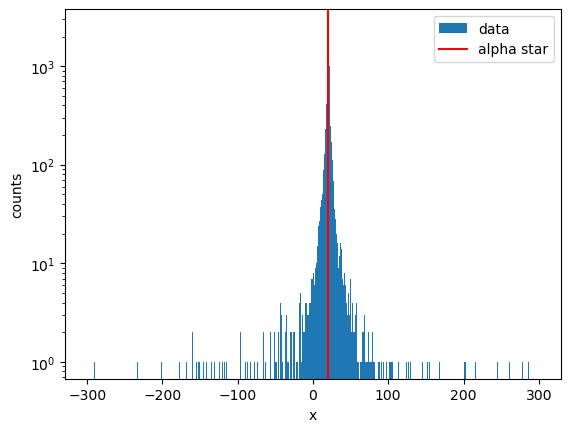

In [26]:
# Solution
astar = 20
n = 10000
data = generate_dataset(astar, n)
plt.hist(data, bins = range(-300,300), label = "data")
plt.axvline(astar, color = 'red', label = "alpha star")
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('counts')
plt.legend()
plt.show()

**2.1.3 (1pt)** Answer the following questions.

1. Around which value of $x$ is the histogram peaked? Motivate your answer.
2. Which values of the angle $\theta$ correspond to the extreme values (the rare outliers)?

**Solution**

1. The histogram is peaked around the value of $\alpha_*$, as it should be given that most angles will produce detected events around the corresponding position on the coastline. One could also consider a more mathematical viewpoint, reasoning how the non-linear function `tan` alters uniformly spaced points: it packs together around 0 most of the points, and spreads the points next to $\pm \pi/2$ on infinitely long intervals.
2. The outliers are single events detected vey far from the peak due to the corresponding angle being close to $\pm \pi/2$.

**2.1.4 (2pt)** Prove that the probability density function of the random variable $x(\theta)$ is given by
$$
    \rho_{x}(x | \alpha_*) = \frac{1}{\pi(1+(x - \alpha_*)^2)} \, .
$$
Type your derivation in a Markdown cell using LaTeX.

Hints:
1. Write down the p.d.f. of the random variable $\theta$, recalling that it is uniformly distributed on the interval $(-\pi/2, \pi/2)$.
2. Use the change of variable formula for probability density functions (see the Probability and Statistics course).

**Solution**

Recall that $x(\theta) = \tan(\theta) + \alpha_*$.

1. The p.d.f. of a random variable uniformly distributed on the interval $(a, b)$ is zero for $x < a$ and $x>b$, and for $a \leq x \leq b$ it equals
$$
    \rho_{(a,b)}(\theta) = \frac{1}{b-a} \, .
$$
Thus for $-\pi/2 \leq \theta \leq \pi/2$
$$
    \rho_\theta(\theta) = \frac{1}{\pi} \, .
$$

2. The change of variable formula is 
$$
    \rho_{x}(x) = \rho_\theta(\theta) \Big| \frac{d\theta}{dx} \Big|
$$
We need to compute $d\theta/dx$. We have, inverting the relation between $x$ and $\theta$
$$
    \frac{d\theta}{dx} = \frac{d}{dx} \arctan(x - \alpha_*) = \frac{1}{1+(x - \alpha_*)^2} \, ,
$$
from which we obtain
$$
    \rho_{x}(x | \alpha_*) = \frac{1}{\pi(1+(x - \alpha_*)^2)} \, .
$$

**2.1.5 (1pt)** 
Reproduce the plot you did in 2.1.2. 
This time, use the option ```density = True``` in the histogram (to plot frequencies instead of counts on the y axis), and plot in black the p.d.f. $\rho_x$ you derived at the previous point on top of it.
Plot from $x=-100$ to $x=100$.

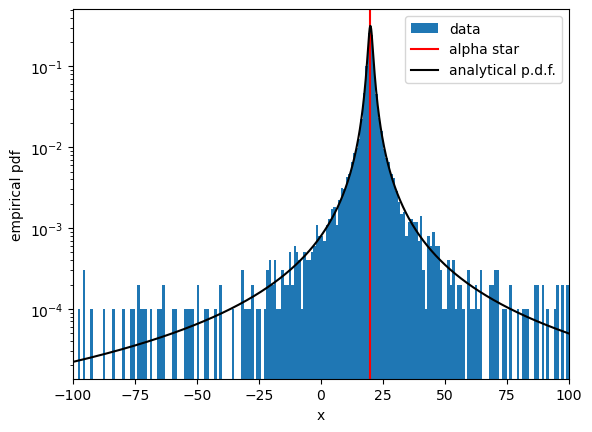

In [11]:
# Solution
astar = 20
n = 10000
data = generate_dataset(astar, n)
plt.hist(data, bins = range(-300,300), label = "data", density = True)
plt.axvline(astar, color = 'red', label = "alpha star")
xs = np.linspace(-100,100,1000)
ys = 1/(1+(xs - 20)**2)/np.pi
plt.plot(xs, ys, color = "black", label = "analytical p.d.f.")
plt.xlim(-100,100)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('empirical pdf')
plt.legend()
plt.show()

### Ex 2.2: estimation of $\alpha_*$ through maximum likelihood

In this section, we implement the maximum likelihood estimator for $\alpha$, and use it to estimate $\alpha_*$ in the given dataset.

**2.2.1 (0.5pt)** 
Use ```np.load``` to load the file "data-lighthouse.npy" into a variable called ```dataset```. 
This will be your set of observations for this part of the exercise, in which we will try to estimate the value $\alpha_*$ used to generate the dataset. 
How many measurements does it contain?

In [27]:
# Solution
dataset = np.load("data-lighthouse.npy")
print(dataset.shape)

(50,)


**Solution** 

It contains 50 measurements.

**2.2.2 (2pt)** Prove that the maximum likelihood estimator (MLE) $\hat{\alpha}$ is given by
$$
\hat{\alpha} = \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2) = \arg\min_{\alpha} f(\alpha, \{x_i\}_{i=1}^n)
$$
Type your derivation in a Markdown cell using LaTeX.

Hints: 
- you can follow and adapt the many examples of MLE given in class to this specific problem. 
- It is useful to maximise the log-likelihood instead of the likelihood to convert products into sums (recall that logs do not alter the position of maxima). 
- $\max[f(x)] = \min[- f(x)]$.

**Solution**

The maximum likelihood estimator is 
$$
\hat{\alpha} 
= \argmax_{\alpha} \prod_{i=1}^n \frac{1}{\pi(1+(x_i - \alpha)^2)}
= \argmax_{\alpha} \sum_{i=1}^n \log \frac{1}{\pi(1+(x_i - \alpha)^2)}
= \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2) - n \log \pi
= \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2)
$$

**2.2.3 (1pt)** Write a function that takes as input $\alpha$ and the dataset (a length $n$ vector) and computes $f(\alpha, \{x_i\}_{i=1}^n)$.

In [28]:
# Solution
def f(a, dataset):
    return np.sum(np.log(1+(dataset - a)**2))

**2.2.4 (1.5pt)** Plot the function $f(\alpha, \{x_i\}_{i=1}^n)$ as a function of $\alpha$ and the given dataset. Plot it for $-10 < \alpha < 30$.
What can you deduce about the value of $\hat{\alpha}$ from the plot?

Text(0, 0.5, 'f(alpha)')

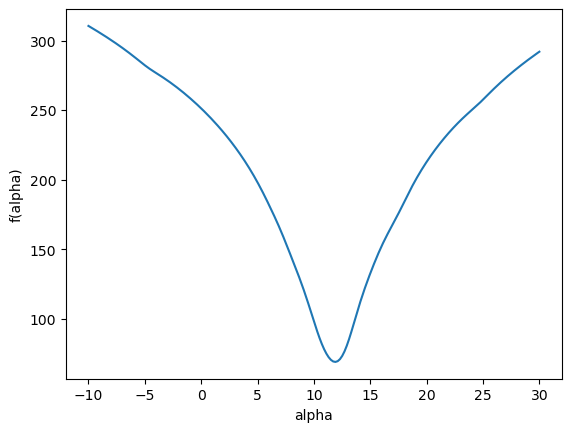

In [29]:
# Solution 
xs = np.linspace(-10,30,200)
ys = [ f(x, dataset) for x in xs]
plt.plot(xs, ys)
plt.xlabel("alpha")
plt.ylabel("f(alpha)")

**Solution**

The MLE stimator is in the surrounding of $\alpha \approx 12$.

**2.2.5 (1pt)** Minimize numerically $f$ for your dataset and compute the MLE. Use ```x0=0``` for the initial condition of the minimization. Print the MLE that you obtain.

In [30]:
# Solution
ahat = (scipy.optimize.minimize(lambda a: f(a, dataset), 0).x)[0]
print(ahat)

11.887987569217566


**2.2.6 (1pt)** 
Reproduce the plot you did in 1.2.4.. 
Additionaly, plot a vertical line at  $x = \hat{\alpha}$ and add a legend.

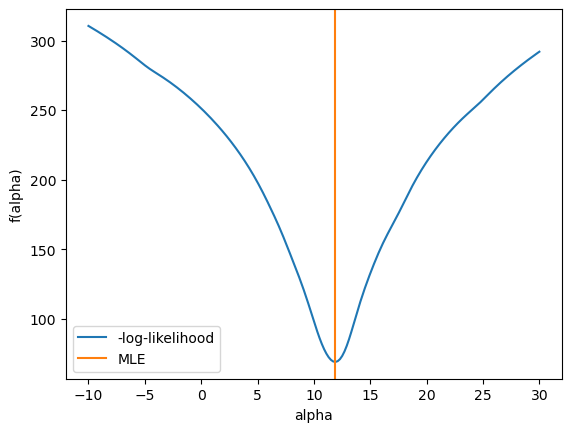

In [16]:
# Solution 
xs = np.linspace(-10,30,200)
ys = [ f(x, dataset) for x in xs]
plt.plot(xs, ys, label = "-log-likelihood")
plt.xlabel("alpha")
plt.ylabel("f(alpha)")
plt.axvline(x=ahat, color = "tab:orange", label="MLE")
plt.legend()

### Ex 2.3: law of large numbers and central limit theorem for the MLE estimator

Recall that the MSE estimator, and more in general every estimator, is a function of the dataset, i.e.
$$
    \hat{\alpha} = \hat{\alpha}(x_1, \dots, x_n) \, .
$$
Thus, given that the dataset is a random event (different runs of the experiment will produce different datasets), the estimator itself is a random variable. 
We say that the estimator is **unbiased** if on average it retrieves the correct value of $\alpha$
$$
    \mathbb{E}(\hat{\alpha}) = \alpha_* \, .
$$
Moreover, it can happen that an estimator satisfies a law of large numbers, i.e. that as $n \to \infty$
$$
    \hat{\alpha} \to \mathbb{E}(\hat{\alpha}) \, .
$$
This means that the more measurements we have, the less randomness the estimator $\hat{\alpha}$ will exhibit, to the point that for $n \to \infty$ it is not a random quantity anymore (it has no fluctuations), and retrieves exactly the value $\mathbb{E}(\hat{\alpha})$, which is the correct value $\alpha_*$ **only if** the estimator is unbiased.

More in detail, for $n\to\infty$:
1. the MLE estimator satisfies a law of large numbers (LLN) and is unbiased, i.e. 
$$
    \hat{\alpha} \to \alpha_* \, .
$$
2. The MLE estimator satisfies a central limit theorem (CLT), i.e. the fact that the fluctuations of the MLE around the true value are Gaussian with variance decreasing as $\sim 1/\sqrt{n}$
$$
    \hat{\alpha} - \alpha_* \sim N(0, \text{const} / \sqrt{n}) \, .
$$

This can be equivalently phrased as the fact that the standardised MLE
$$
    \hat{\alpha}_{\rm std} = \frac{\hat{\alpha} - \mathbb{E}(\hat{\alpha})}{\sqrt{\text{Var} (\hat{\alpha})}}
$$
is distributed as a standard Gaussian (mean = 0, variance = 1).

In this section, we will explore these properties for the MLE. 

**2.3.1 (1pt)** Write a function that takes as input a dataset and returns the MLE by combining the code you already wrote in exercise 2.2.

In [31]:
# Solution
def MLEalpha(dataset):
    return (scipy.optimize.minimize(lambda a: np.sum(np.log(1+(dataset - a)**2)), 0).x)[0]

To study the randomness of the estimator $\hat{\alpha}$ as a function of $n$, we need to generate many experiments at a fixed size $n$, and study the mean and standard deviation of the corresponding MLEs.

**2.3.2 (2pt)** For ```n in np.arange(10,10000,200)```:
- generate $k=50$ datasets with $\alpha_* = 20$ and $n$ measurements.
- Compute the MLE for each of the $k$ datasets, and store the $k$ MLE obtained in a vector.
- Compute the empirical mean and empirical standard deviation of the sample of the $k$ MLE obtained.

Store all the empirical means and standard deviations in two respective vectors. 
The two vectors obtained should have the same length of ```ns```: check this by priting the lengths of the three vectors.

In [32]:
# Solution
ns = np.arange(10,10000,200)
k=50

means = []
stds = []

for n in ns:
    MLEs = []
    for _ in range(k):
        MLEs = np.append(MLEs, MLEalpha(generate_dataset(20,n)))

    mean_value = np.mean(MLEs)
    std_dev = np.std(MLEs)

    means = np.append(means, mean_value)
    stds = np.append(stds, std_dev)

print(means.shape)
print(stds.shape)
print(ns.shape)

(50,)
(50,)
(50,)


**2.3.3 (1pt)** Plot the empirical means vs ns on one plot, and the standard deviations vs ns on **another** plot. 
For the plot of the mean, add a horizontal line at $y=\alpha_*$.
For the plot of the standard deviation, set the scale of the plot to log-log. 

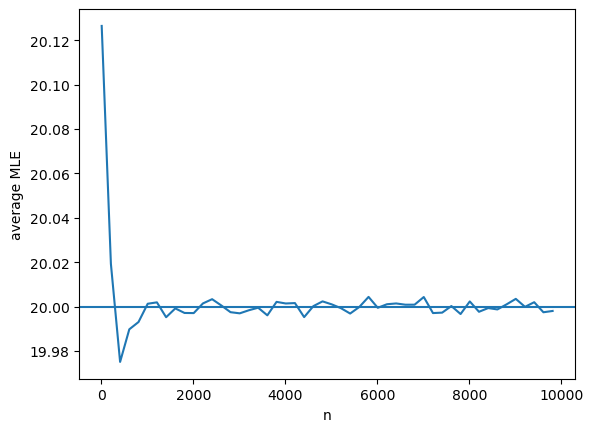

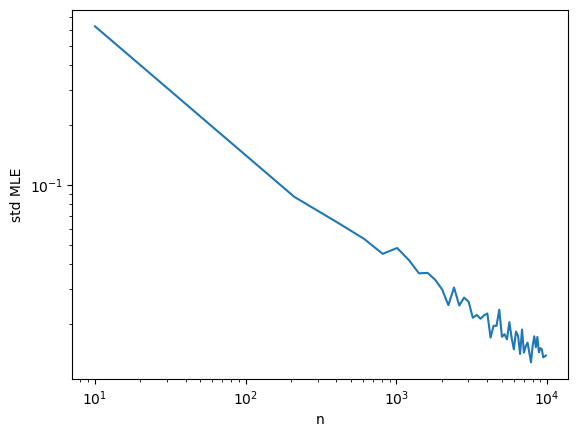

In [33]:
# Solution
plt.plot(ns, means)
plt.axhline(y=20)
plt.xlabel("n")
plt.ylabel("average MLE")
plt.show()

plt.plot(ns, stds)
plt.xlabel("n")
plt.ylabel("std MLE")
plt.yscale('log')
plt.xscale('log')

plt.show()

**2.3.4 (3pt)** Discuss:
- is the mean behaving according to the law of large numbers?
- is the standard deviation behaving according to the central limit theorem? Describe qualitatively the meaning of the slope of the plot when log-log scale is used, and related this to the rate of decay of the standard deviation predicted by the CLT.

**Solution**

1. The mean of the MLEs quickly converges to the true value $\alpha_* = 20$.
2. The standard deviation is going to zero, compatibly with the LLN and the CLT.
    On a log-log plot, a power law between $x$ and $y$, for example $y = x^{\gamma}$, gets translated to a linear relationship $\log y = \gamma \log x$. Thus, the slope of a curve in a log-log plot is a sign of a power law relationship between the non-log variables. In this case, the slope of the plot in log-log scale is roughly -1/2 (for each 2 decades on the x axis, the curve decreases of 1 decade on the y axis), meaning that the rate of convergence to 0 is compatible with the rate $\frac{1}{\sqrt{n}}$ predicted by the CLT.

The CLT gives us more detailed informations about the distribution of the standardised MLE, saying that the distribution is a standard Gaussian. Let us verify that.

**2.3.5 (2pt)** For ```n in ns=[15,30,50,100]```:
- generate $k=1000$ datasets with $\alpha_* = 20$ and $n$ points.
- Compute the MLE for each of the $k$ datasets, and store the $k$ MLE obtained in a vector.
- Compute the empirical mean and standard deviation of the $k$ MLE obtained.
- Standardise the vector of the $k$ MLE, i.e. subtract the mean and divide by the standard deviation from each MLE.
- Plot the histogram of the $k$ standardised MLEs. Use 50 bins, add a label = n, and use ```density = True``` (to plot frequencies) and ```alpha = 0.5``` to use a semi-transparent filling color.

All histograms should appear on the same plot, and the plot should have a legend.
On the same plot, draw the p.d.f. of a standard gaussian for $-5 < x < 5$ in black.

Hint: modify your code from 2.3.2.

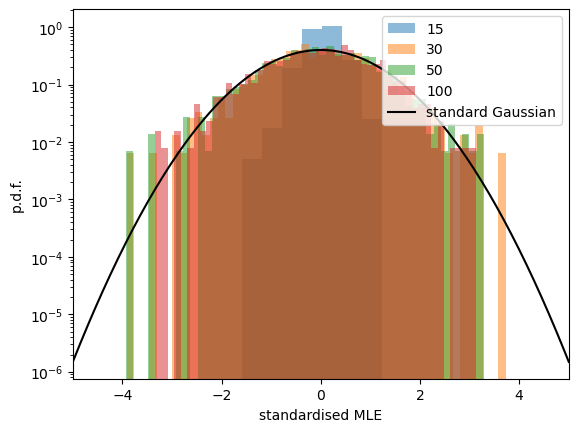

In [34]:
# Solution
ns = [15,30,50,100]
k=1000

for n in ns:
    MLEs = []
    for _ in range(k):
        MLEs = np.append(MLEs, MLEalpha(generate_dataset(20,n)))

    mean_value = np.mean(MLEs)
    std_dev = np.std(MLEs)

    MLEs = (MLEs-mean_value)/std_dev
    plt.hist(MLEs, bins = 50, density = True, label = n, alpha = 0.5)

xs = np.linspace(-5, 5, 200)
ys = np.exp(-0.5 * xs**2) / np.sqrt(2 * np.pi)
plt.plot(xs, ys, color = "black", label = "standard Gaussian")

plt.xlim(-5,5)
plt.yscale('log')
plt.xlabel("standardised MLE")
plt.ylabel("p.d.f.")
plt.legend()
plt.show()

**2.3.6 (1pt)** Comment the previous plot. Is the central limit theorem verified? Motivate your answer. 

**Solution**

As $n$ increases, the distribution of the standardised MLEs approaches a standard Gaussian as predicted by the CLT.

### 2.4 Comparison with other estimators

In this section, we compare the MLE with two other estimators, the empirical mean and the empirical median of the measurements.

##### Empirical mean

The simplest estimator we could have considered for this estimation task is simply the empirical average of the measurement
$$
    \hat{x} = \frac{1}{n} \sum_{i=1}^n x_i \, .
$$

**2.4.1 (1pt)** Compute the empirical average of the dataset we used in exercise 2.2. Comment: Is it as good as the MLE? 

In [35]:
# Solution
hatx = np.mean(dataset)
print(hatx)

14.867385800153468


**Solution**

We cannot judge if this value is better than the MLE a priori, as we do not know the ground truth value.

To study the randomness of the empirical mean estimator as a function of $n$, we need to generate many experiments at a fixed size $n$, and study the mean and standard deviation of the corresponding empirical mean estimators. We did this already in Exercise 1.3 for the MLE.

**2.4.2 (1pt)** 
For ```np.arange(10,10000,200)```:
- generate $k=50$ datasets with $\alpha_* = 20$ and $n$ measurements.
- Compute the **empirical mean estimator** for each of the $k$ datasets, and store the $k$ estimators obtained in a vector
- Compute the empirical mean and standard deviation of the $k$ **empirical mean estimators** obtained

Store all the means and standard deviations in two respective vectors. 

Then plot the means vs ns on one plot, and the standard deviations vs ns on **another** plot. 
For the mean plot, add a horizontal line at $y=\alpha_*$.
For the standard deviation plot,  set the scale of the plot to log-log.

Hint: you can reuse code from exercise 2.3.2 and 2.3.3 with minimal modifications.

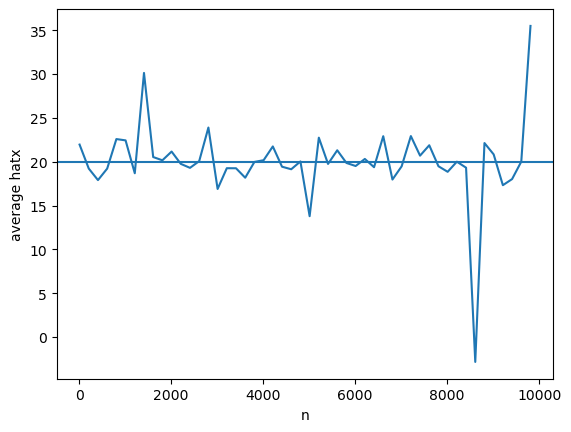

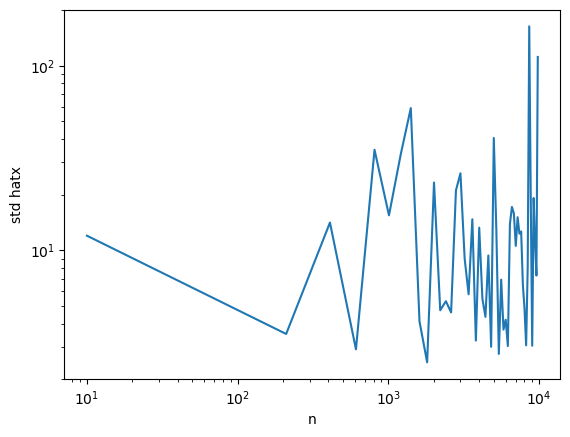

In [36]:
# Solution
ns = np.arange(10,10000,200)
k=50

means = []
stds = []

for n in ns:
    hatxs = []
    for _ in range(k):
        hatxs = np.append(hatxs, np.mean(generate_dataset(20,n)))

    mean_value = np.mean(hatxs)
    std_dev = np.std(hatxs)

    means = np.append(means, mean_value)
    stds = np.append(stds, std_dev)

plt.plot(ns, means)
plt.axhline(y=20)
plt.xlabel("n")
plt.ylabel("average hatx")
plt.show()

plt.plot(ns, stds)
plt.xlabel("n")
plt.ylabel("std hatx")
plt.yscale('log')
plt.xscale('log')

plt.show()

**2.4.3 (2pt)** Discuss the previous plots.

1. Does the standard deviation go to zero? 
2. Given your answer to the previous question, is a law of large numbers holding for the empirical mean estimator in this case? 

**Solution**

1. The standard deviation fluctuates around a constant value $\approx 10$, and does not go to zero. 
3. The estimator does not satisfy a law of large numbers, as a LLN requires that the estimator is not random anymore in the large $n$ limit (i.e. has zero standard deviation), while here the standard deviation deos not go to zero.

**A comment:** in class we saw that the empirical mean estimator **does converge** to the true mean of the $\rho_x(x)$ distribution, which seems incompatible with our observations in 2.4.2. and 2.4.3.. There must be some assumption that we did in class that does not hold here. 
Indeed, the mean of the p.d.f. $\rho_x$ is given by the integral
$$
    \mathbb{E}(x) 
    = \int_{-\infty}^{+\infty} dx \, \frac{x}{\pi(1+(x - \alpha_*)^2)}
    = \alpha_* + \int_{-\infty}^{+\infty} dy \, \frac{y}{\pi(1+y^2)}
$$
where we used the change of variable $y = x - \alpha_*$ and the fact that $\rho_x$ is normalised.
The last integral does not exists, as (recalling the definition of improper integral) the limit
$$
    \lim_{R_1, R_2 \to +\infty} \int_{-R_1}^{+R_2} dy \, \frac{y}{1+y^2}
$$
does not converge. 
You can see this by noticing that if one takes the limit $R_2 \to +\infty$ first, the integral diverges to $+\infty$, while if one takes the limit $R_1 \to +\infty$ first, the integral diverges to $-\infty$.

Now, recall that the existence of the mean of a p.d.f. is a necessary condition for a LLN to hold, so this explains why a LLN is not holding here.

You may notice that if we take the limit setting $R_1 = R_2$ the integral converges to zero, the value we would expect intuitively due to symmetry. 
This way of performing the integral is called _principal value_ integration. 
Notice that even tough principal value integration give us a finite mean, the law of large numbers still does not apply.



#### Empirical median

Another simple estimator we could have looked at is the median of the measurements, i.e.
$$
    x_{\rm median} = \text{Median}(x_1, \dots,x_n) \, .
$$
Recall that the empirical median is the element $x_i$ such that half of the other measurements are smaller then $x_i$, and half of the other measurements are bigger than $x_i$.

**2.4.4. (1pt)** Compute the empirical **median** of the dataset we used in exercise 2.2 (there is a numpy function to do that). Is it as good as the MLE? 

In [37]:
# Solution
medianx = np.median(dataset)
print(medianx)

11.898781924739197


**Solution** 

The median estimator is numerically very similar to the MLE, but again we cannot judge the goodness of our estimators a priori.

To study the randomness of the empirical median estimator as a function of $n$, we need to generate many experiments at a fixed size $n$, and study the mean and standard deviation of the corresponding empirical median estimators. We did this already in 2.3.2, 2.3.3 and 2.4.2 for the MLE and for the empirical mean estimator.

**2.4.5. (1pt)** 

For ```n in ns=np.arange(10,10000,200)```:
- generate $k=50$ datasets with $\alpha_* = 20$ and $n$ measurements.
- Compute the **empirical median** estimator for each of the $k$ datasets, and store the $k$ estimators obtained in a vector.
- Compute the empirical mean and standard deviation of the $k$ **empirical median** estimators obtained.

Store all the means and standard deviations in two respective vectors. 

Then plot the means vs ns on one plot, and the standard deviations vs ns on **another** plot. 
For the mean plot, add a horizontal line at $y=\alpha_*$.
For the standard deviation plot, set the the scale of the plot to log-log. 

Hint: you can reuse code from 2.3.2, 2.3.3 and 2.4.2 with minimal modifications.

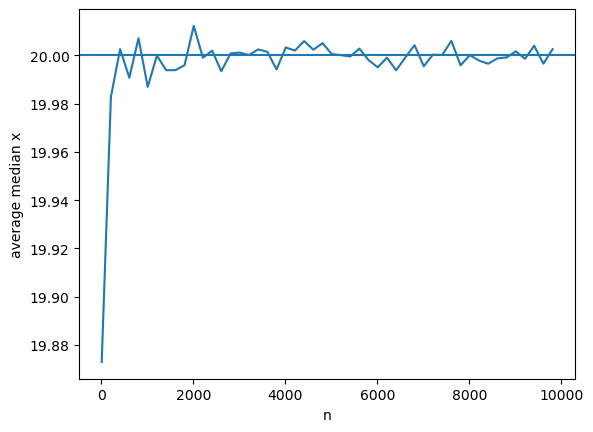

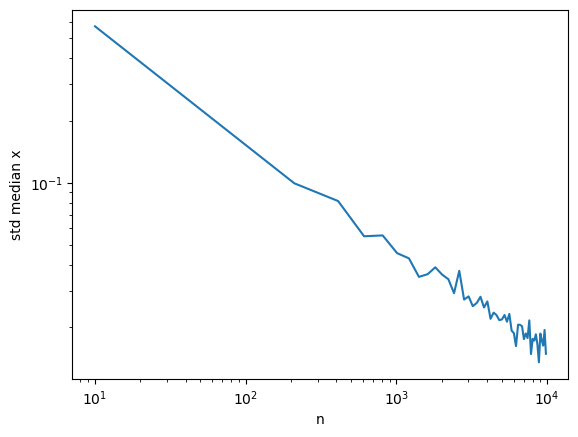

In [38]:
# Solution
ns = np.arange(10,10000,200)
k=50

means = []
stds = []

for n in ns:
    hatxs = []
    for _ in range(k):
        hatxs = np.append(hatxs, np.median(generate_dataset(20,n)))

    mean_value = np.mean(hatxs)
    std_dev = np.std(hatxs)

    means = np.append(means, mean_value)
    stds = np.append(stds, std_dev)

plt.plot(ns, means)
plt.axhline(y=20)
plt.xlabel("n")
plt.ylabel("average median x")
plt.show()

plt.plot(ns, stds)
plt.xlabel("n")
plt.ylabel("std median x")
plt.xscale('log')
plt.yscale('log')


plt.show()

**2.4.6. (2pt)** Discuss the plots above:
1. Is the empirical median estimator converging to something? If so, to which value?
2. Is the standard deviation converging to zero? If so, can you give a qualitative estimate of the rate of decay?

**Solution**

1. The empirical median estimator seems to converge to $\alpha_*$ as $n$ increases., as its mean converges to the true value of $\alpha_*$.
2. The standard deviation seems to be going to zero with rate $1/\sqrt{n}$ (the slope in the log-log plot is roughly -1/2, one decade decrease on y for each decade increase on x).

**2.4.7. (1pt)** Can you find the reason why the empirical median estimator seems to work? 

Hint: what is the median of $\rho_x$?

**Solution**

The distribution we are considering, $\rho_x$, has a median, and by symmetry of $\rho_x$ one sees that the median is exactly equal to $\alpha_*$. The existence of the median explains why the empirical median estimator is more well behaved than the empirical mean estimator. The fact that the true median of the distribution $\rho_x$ equals $\alpha_*$ explains why the empirical median estimators estimates the correct quantity. 

**A comment:** seeing that the median works so well, you might wonder why don't we use that always instead of doing maximum likelihood estimation. The reason is that the median works here only because the median of the distribution of the measurements $\rho_x$ is specially related to $\alpha_*$, which is not at all always the case! So the median works nicely only in a limited amount of cases, while MLE will always work.